In [1]:
%%capture
!pip install plotly
!pip install nltk
!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Visualisierungen
- Mean Sentiment over time per party
- Sentiment per MP
-  Männliche vs. weibliche Politiker vergleich
- Minority vergleich (überhaupt möglich?)
- Hate unter Politikern
- Wordclouds

In [18]:
#df = pd.read_csv("control_group_mentions_predicted_exploded.csv")

# Bei Control Group ohne Exploded, weil ich nicht alle Usernames von 2021 hab. Deswegen z.B. FDP mit nur paar Tweets bei Exploded und merged
# Vielleicht so viele Namen es geht manuell nachtragen?
df = pd.read_csv("../full_datasets/control_group_mentions_predicted.csv")
#df = df.drop(['Unnamed: 0'], axis=1)
df.head()
len(df)

/tmp/ipykernel_1080/3505068083.py:4: DtypeWarning:

Columns (2,3,5,11,12) have mixed types. Specify dtype option on import or set low_memory=False.



1534833

In [21]:
df["party"] = df["Partei"]

In [22]:
#df = df[df["party"] != " fraktionslos "]
df.drop(df.loc[df["party"]==" fraktionslos"].index, inplace=True)

In [23]:
df.party.value_counts()

SPD                      572923
Bündnis 90/Die Grünen    304495
CSU/CDU                  295422
AfD                       92319
FDP_polis_1               54101
Die Linke                 54101
Name: party, dtype: int64

In [24]:
#df = df.sample(10000)
df.head(5)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,quote_count,retweets,replies,likes,mentioned,Runs,Partei,model_predictions,party
0,0,0,693298,1412000720321134598,Delbertalexan10,33,3165,Biographie? Echt interessant...,NaN,@M_Richter65 @SMBAH05 @RTLde @kloeppelpeter @A...,2021-08-24 21:18:03+00:00,0.0,0.0,0.0,0.0,"['M_Richter65', 'SMBAH05', 'RTLde', 'kloeppelp...",Gruene_polis_1,Bündnis 90/Die Grünen,1,Bündnis 90/Die Grünen
1,1,1,693299,1225125362763489281,Hsnbrg_eiee,18,770,Kritik der reinen Emotion,Stgt,@Super_Sastre @TinaHassel @ABaerbock Meinen Si...,2021-08-24 21:18:03+00:00,0.0,0.0,0.0,1.0,"['Super_Sastre', 'TinaHassel', 'ABaerbock']",Gruene_polis_1,Bündnis 90/Die Grünen,0,Bündnis 90/Die Grünen
2,2,2,693300,1323344585297453056,ZweiteLudwig,2717,16927,"Du bist, was du isst. (Ludwig Feuerbach)\nGebo...",NaN,"@TinaHassel @ABaerbock Man entschuldigt sich, ...",2021-08-24 21:17:54+00:00,0.0,0.0,0.0,0.0,"['TinaHassel', 'ABaerbock']",Gruene_polis_1,Bündnis 90/Die Grünen,0,Bündnis 90/Die Grünen
3,3,3,693302,4920299411,urgberlin,0,2596,NaN,NaN,@EmmeEsse15 @RTLde @ABaerbock @kloeppelpeter W...,2021-08-24 21:17:28+00:00,0.0,0.0,0.0,0.0,"['EmmeEsse15', 'RTLde', 'ABaerbock', 'kloeppel...",Gruene_polis_1,Bündnis 90/Die Grünen,0,Bündnis 90/Die Grünen
4,4,4,693304,1387018416784093185,Jermain95498334,807,10110,#teamreitschuster ☝🏼GETTR bo_germaine 💙,NaN,@TinaHassel @ABaerbock Journalisten im Merkell...,2021-08-24 21:17:22+00:00,0.0,0.0,0.0,0.0,"['TinaHassel', 'ABaerbock']",Gruene_polis_1,Bündnis 90/Die Grünen,1,Bündnis 90/Die Grünen


# Data Analysis

In [25]:
# because on mention row was found in the created_at column
df = df[~df['created_at'].astype(str).str.startswith('[')]
df = df[~df['created_at'].astype(str).str.startswith('S')]
df = df[~df['created_at'].astype(str).str.startswith('F')]
df = df[~df['created_at'].astype(str).str.startswith('C')]
df = df[~df['created_at'].astype(str).str.startswith('A')]
df = df[~df['created_at'].astype(str).str.startswith('D')]
df = df[~df['created_at'].astype(str).str.startswith('B')]

In [26]:
df["created_at"][0]

'2021-08-24 21:18:03+00:00'

In [27]:
df["created_at"] = df["created_at"].astype('datetime64[ns]') 
df["created_at"] = df.created_at.dt.to_pydatetime()

In [28]:
len(df)

1534815

In [29]:
# Date Spalte erstellen
df["Date"]  = df["created_at"]
#df['Date']= pd.to_datetime(df['Date'])

df["HOF"] = df["model_predictions"]
df.loc[(df.model_predictions == 1),'Label']='HOF'
df.loc[(df.model_predictions == 0),'Label']='NOT'

In [30]:
df.head(2)

,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,...,replies,likes,mentioned,Runs,Partei,model_predictions,party,Date,HOF,Label
0,0,0,693298,1412000720321134598,Delbertalexan10,33,3165,Biographie? Echt interessant...,NaN,@M_Richter65 @SMBAH05 @RTLde @kloeppelpeter @A...,...,0.0,0.0,"['M_Richter65', 'SMBAH05', 'RTLde', 'kloeppelp...",Gruene_polis_1,Bündnis 90/Die Grünen,1,Bündnis 90/Die Grünen,2021-08-24 21:18:03,1,HOF
1,1,1,693299,1225125362763489281,Hsnbrg_eiee,18,770,Kritik der reinen Emotion,Stgt,@Super_Sastre @TinaHassel @ABaerbock Meinen Si...,...,0.0,1.0,"['Super_Sastre', 'TinaHassel', 'ABaerbock']",Gruene_polis_1,Bündnis 90/Die Grünen,0,Bündnis 90/Die Grünen,2021-08-24 21:18:03,0,NOT


In [55]:
df.party.value_counts()

SPD                      572923
Bündnis 90/Die Grünen    304495
CSU/CDU                  295422
AfD                       92319
FDP                       54101
Die Linke                 54101
Name: party, dtype: int64

In [54]:
df["party"] = df["party"].replace("FDP_polis_1", "FDP")
df["Partei"] = df["Partei"].replace("FDP_polis_1", "FDP")

In [32]:
df["party"] = df["party"].replace(" SPD", "SPD")
df["party"] = df["party"].replace(" Bündnis 90/Die Grünen", "Bündnis 90/Die Grünen")
df["party"] = df["party"].replace(" FDP", "FDP")
df["party"] = df["party"].replace(" CDU/CSU", "CSU/CDU")
df["party"] = df["party"].replace(" AfD", "AfD")
df["party"] = df["party"].replace(" Die Linke", "Die Linke")

In [33]:
afd = df[df["party"] == "AfD"]
cducsu = df[df["party"] == "CSU/CDU"]
linke = df[df["party"] == "Die Linke"]
fdp = df[df["party"] == "FDP"]
gruene = df[df["party"] == "Bündnis 90/Die Grünen"]
spd = df[df["party"] == "SPD"]

In [34]:
# group by party and look at sentiment distribution per party
afd_pos = afd[afd["model_predictions"] == 0].username.count()
afd_neg = afd[afd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
spd_pos = spd[spd["model_predictions"] == 0].username.count()
spd_neg = spd[spd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
linke_pos = linke[linke["model_predictions"] == 0].username.count()
linke_neg = linke[linke["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
fdp_pos = fdp[fdp["model_predictions"] == 0].username.count()
fdp_neg = fdp[fdp["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
gruene_pos = gruene[gruene["model_predictions"] == 0].username.count()
gruene_neg = gruene[gruene["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
cducsu_pos = cducsu[cducsu["model_predictions"] == 0].username.count()
cducsu_neg = cducsu[cducsu["model_predictions"] == 1].username.count()

pos = df[df["model_predictions"] == 0].username.count()
neg = df[df["model_predictions"] == 1].username.count()

## Plots over Time

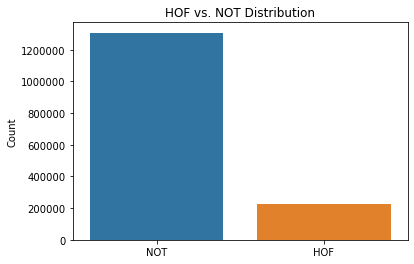

In [35]:
ax = sns.barplot(x=["NOT", "HOF"], y=[pos,neg])
ax.set_title('HOF vs. NOT Distribution')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

In [36]:
ax.figure.savefig("./plots/control_group/control_group_exploded_hof_distribution.png")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



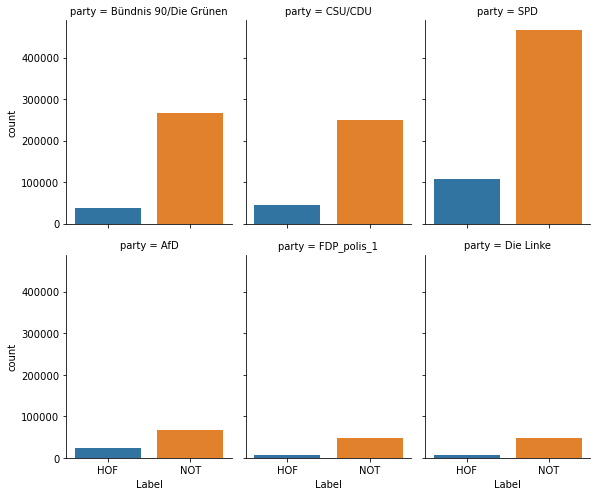

In [37]:
# Plot
g = sns.catplot("Label", col="party", col_wrap=3,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab10')

#fig.suptitle('sf')
plt.show()
g.savefig('./plots/control_group/control_group_exploded_party_hof_distribution.png')

In [38]:
day = []
for index, row in df.iterrows():
    date = row["Date"].date()
    day.append(date)
    
df["day"] = day
df["Partei"] = df["party"]
day_sentiment_df = df.pivot_table(index=['Partei', 'day'], values='model_predictions', aggfunc='mean').reset_index()
day_sentiment_df

,Partei,day,model_predictions
0,AfD,2021-07-01,0.271854
1,AfD,2021-07-02,0.277262
2,AfD,2021-07-03,0.268966
3,AfD,2021-07-04,0.326882
4,AfD,2021-07-05,0.252189
...,...,...,...
367,SPD,2021-08-27,0.174382
368,SPD,2021-08-28,0.177696
369,SPD,2021-08-29,0.155784
370,SPD,2021-08-30,0.175784


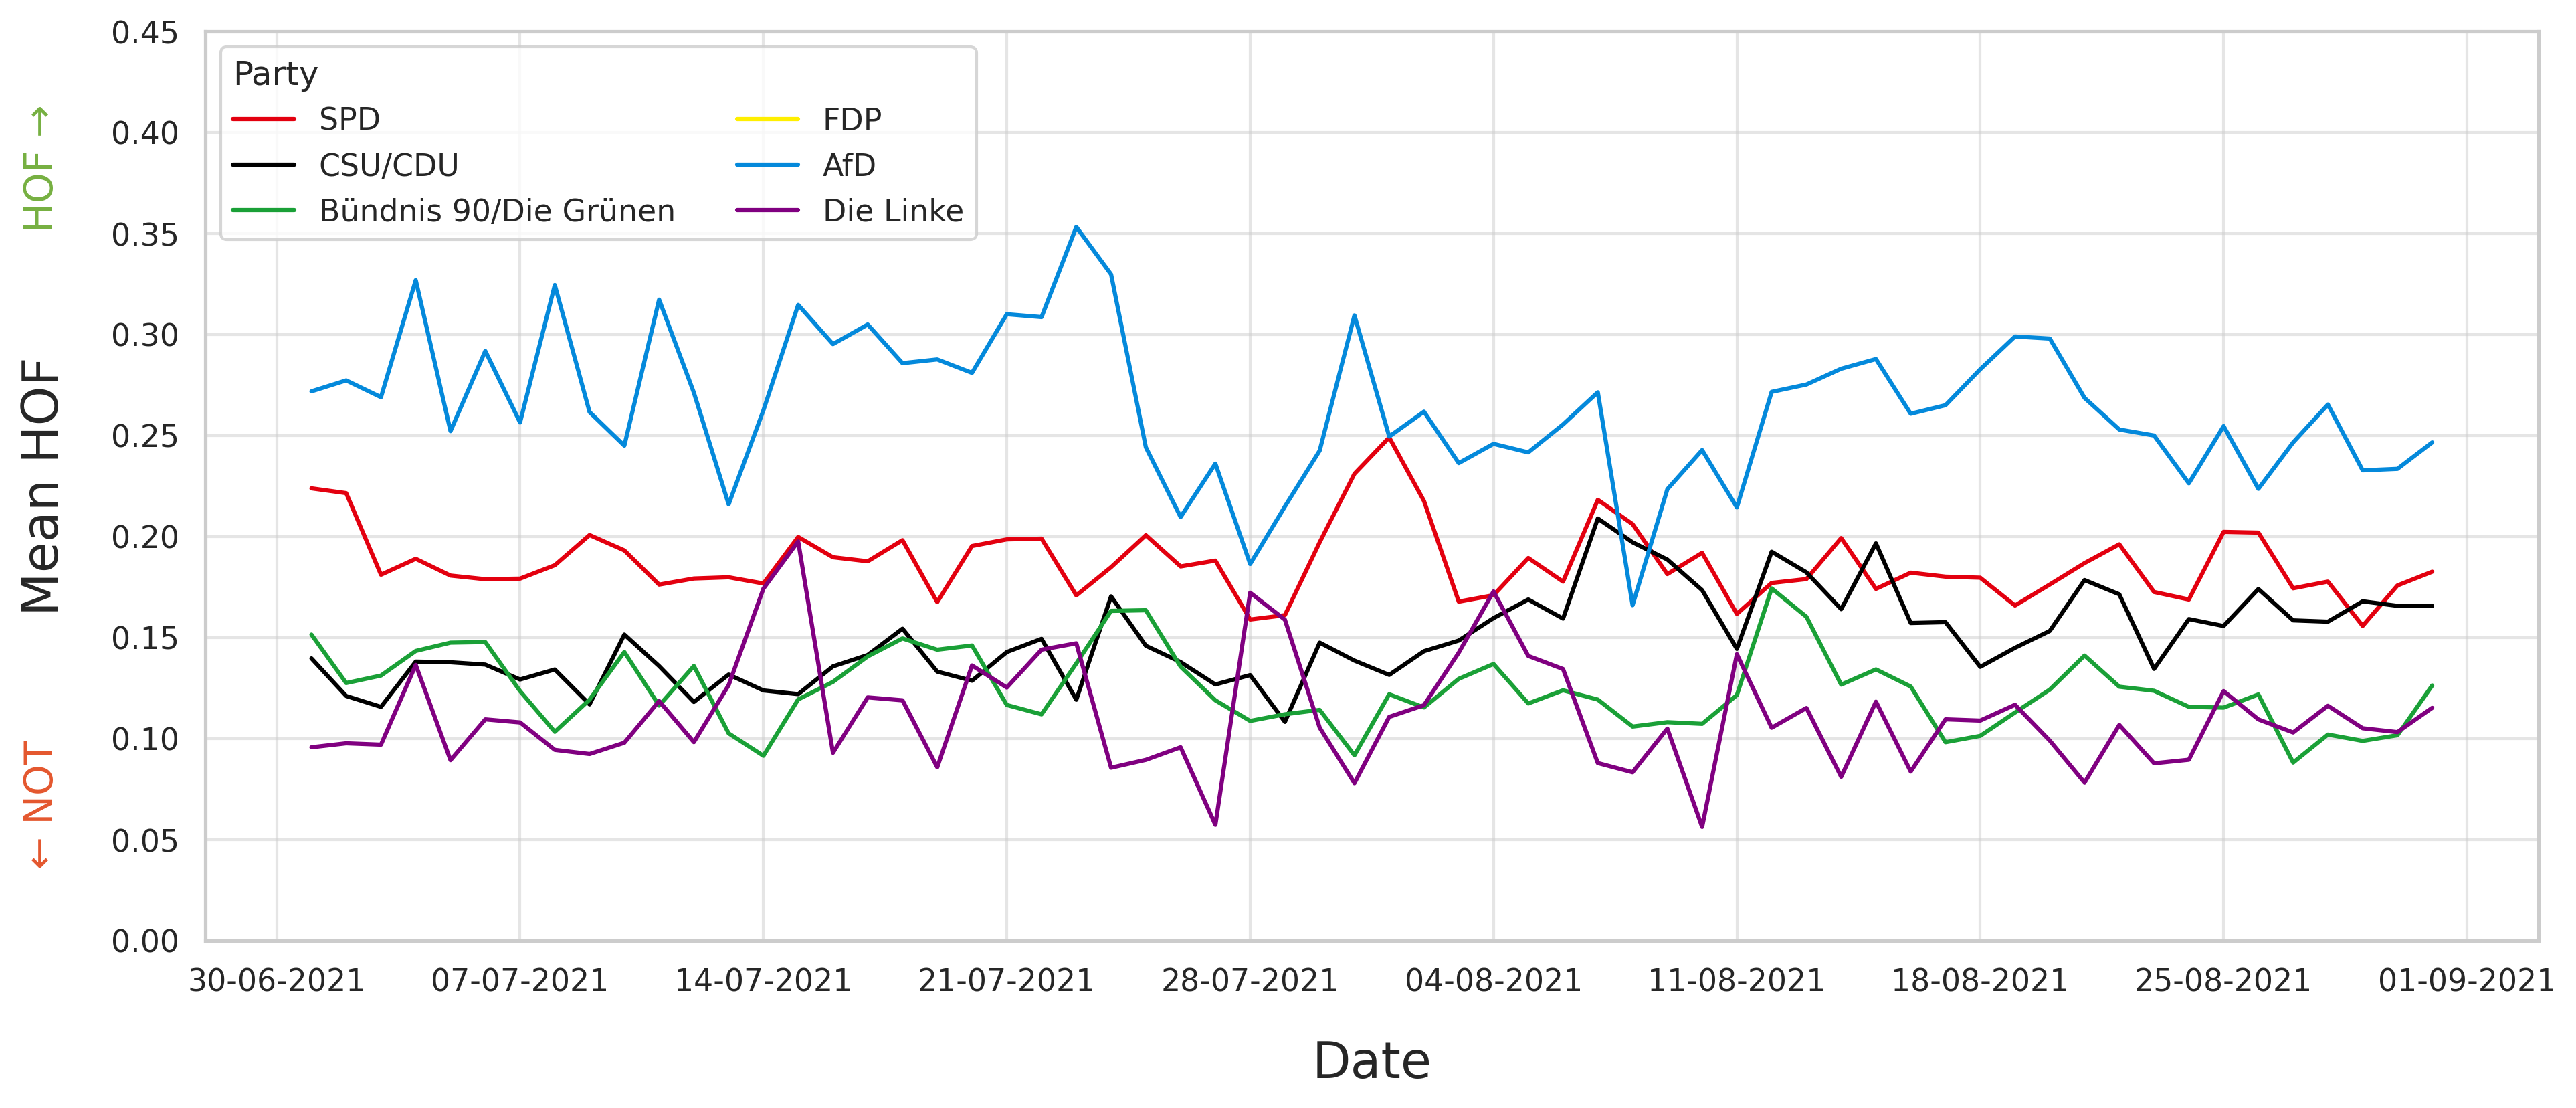

In [39]:
from time_plots import plot_line_graph_for_each_day, plot_reg_line_graph_for_each_day, plot_percentage

plot_line_graph_for_each_day(day_sentiment_df, "./plots/control_group/control_group_exploded_hof_party_over_time")

In [40]:
def f_2021(row):
    if row['party'] == "AfD":
        val = "Opposition"
    elif row['party'] == "Die Linke":
        val = "Opposition"
    elif row['party'] == "CSU/CDU":
        val = "Opposition"
    elif row['party'] == "Bündnis 90/Die Grünen":
        val = "Government"
    elif row['party'] == "FDP":
        val = "Government"
    elif row['party'] == "SPD":
        val = "Government"
    else:
        val = "NA"
    return val

In [41]:
#df['Regierungsstatus_2017'] = df.apply(f_2017, axis=1)
df['Regierungsstatus_2021'] = df.apply(f_2021, axis=1)

In [42]:
#df['day'] = (i.date for in in df["Date"])
reg_day_sentiment_df = df.pivot_table(index=['Regierungsstatus_2021', 'day'], values='model_predictions', aggfunc='mean').reset_index()
reg_day_sentiment_df

,Regierungsstatus_2021,day,model_predictions
0,Government,2021-07-01,0.189809
1,Government,2021-07-02,0.173718
2,Government,2021-07-03,0.155540
3,Government,2021-07-04,0.170370
4,Government,2021-07-05,0.166069
...,...,...,...
181,Opposition,2021-08-27,0.166135
182,Opposition,2021-08-28,0.177022
183,Opposition,2021-08-29,0.172357
184,Opposition,2021-08-30,0.166113


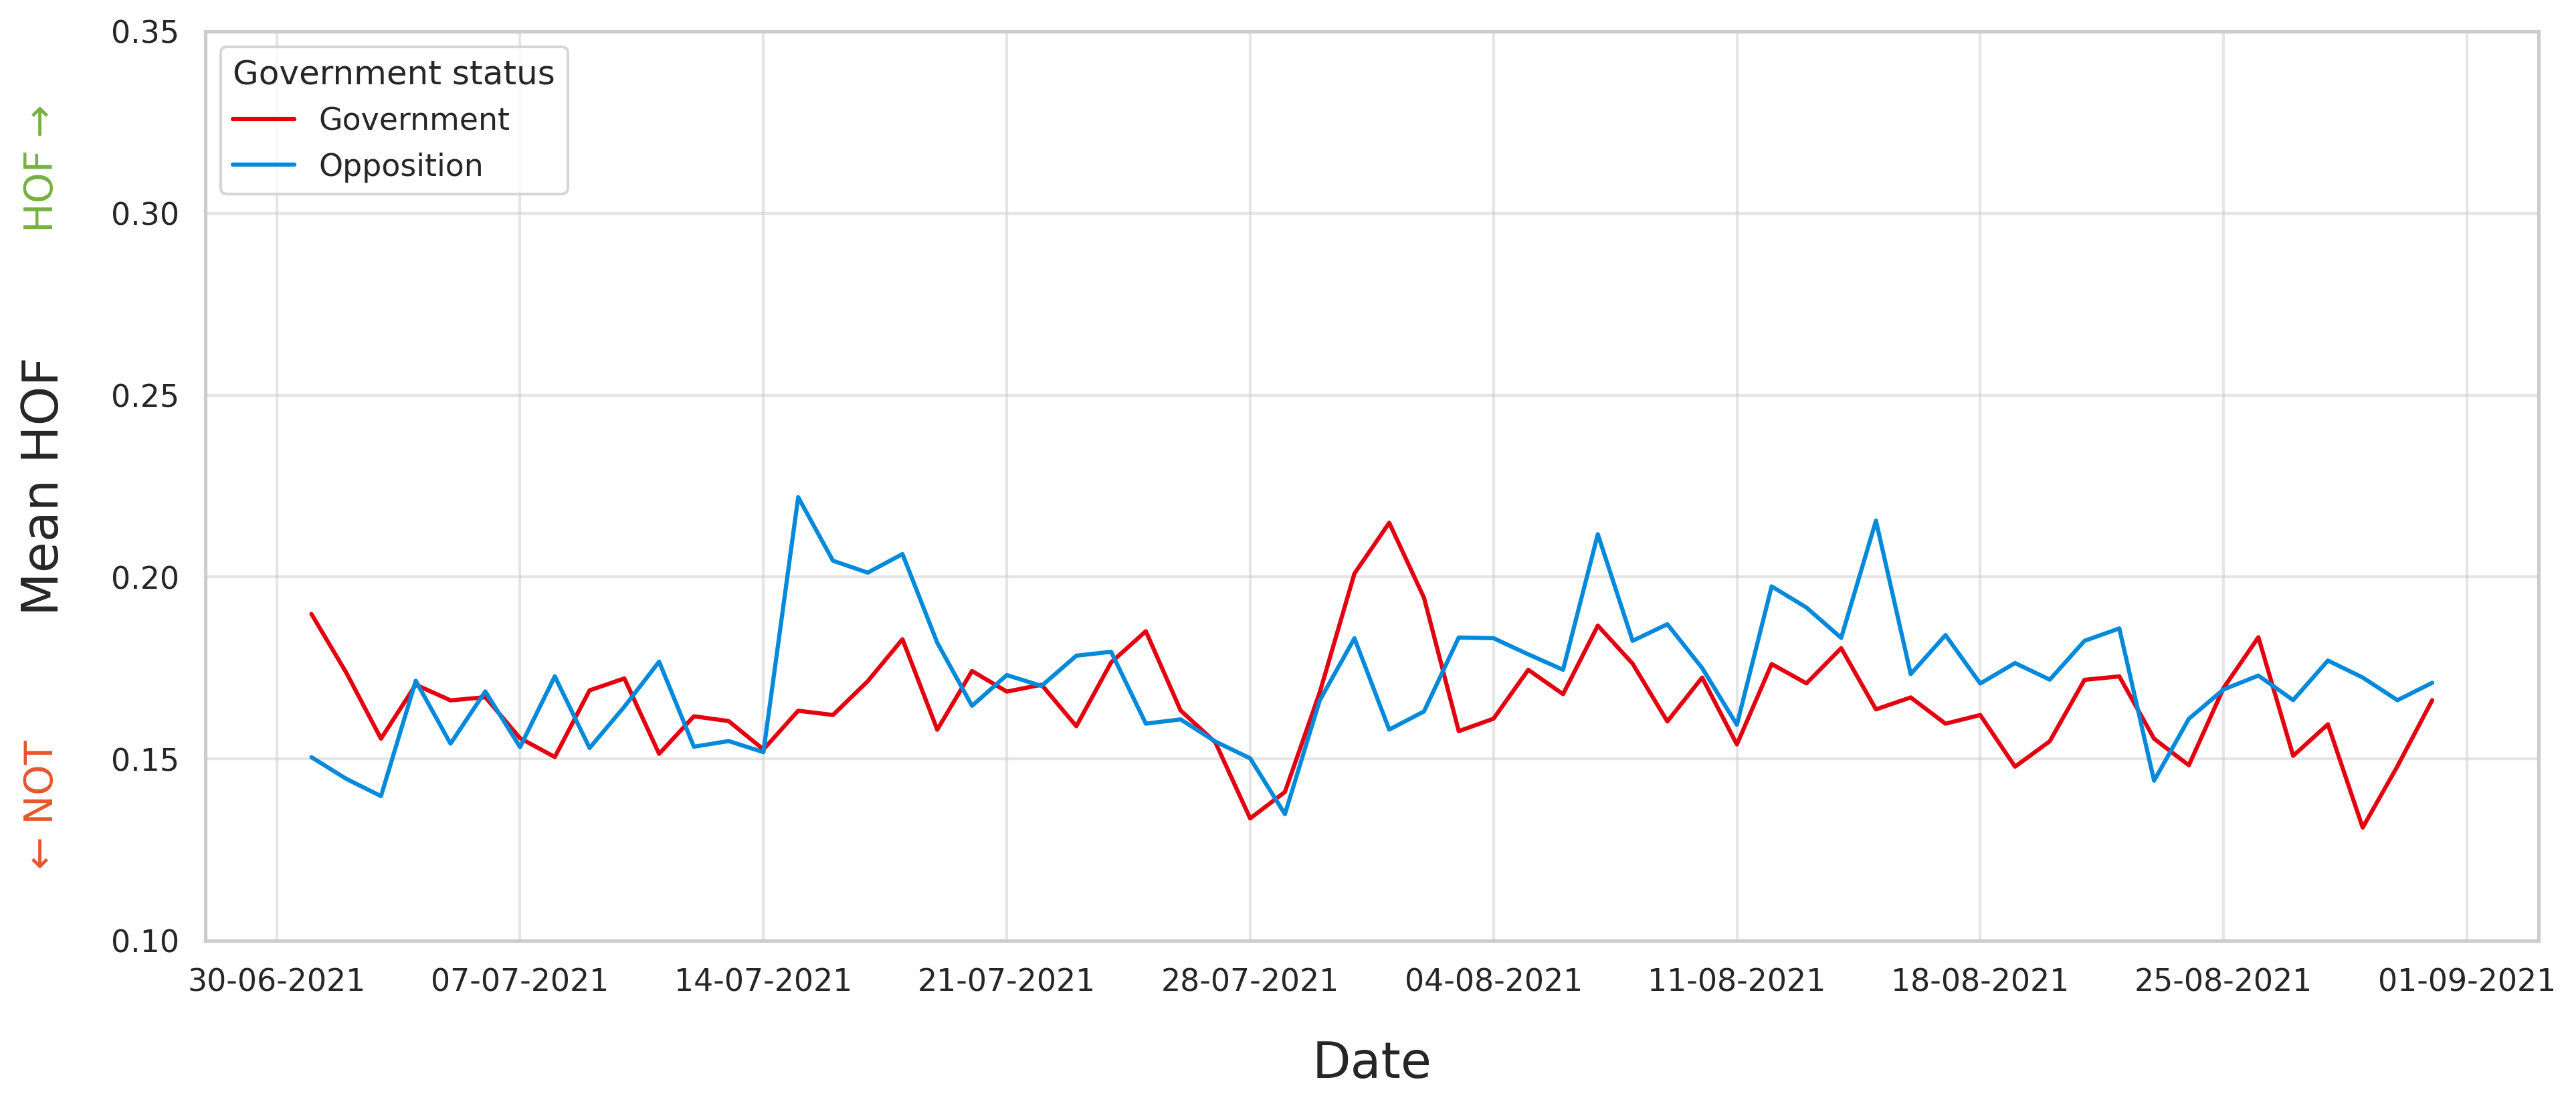

In [43]:
from time_plots import plot_reg_line_graph_for_each_day
plot_reg_line_graph_for_each_day(reg_day_sentiment_df, "./plots/control_group/control_group_exploded_hof_regierung_over_time")

## Plot Percentage Distribution

In [56]:
df["party"].value_counts()

SPD                      572923
Bündnis 90/Die Grünen    304495
CSU/CDU                  295422
AfD                       92319
FDP                       54101
Die Linke                 54101
Name: party, dtype: int64

In [57]:
data = df.groupby(["Partei"])["model_predictions"].value_counts().unstack()
data

model_predictions,0,1
Partei,,
AfD,68100,24219
Bündnis 90/Die Grünen,266356,38139
CSU/CDU,249777,45645
Die Linke,47842,6259
FDP,47842,6259
SPD,466216,106707


In [30]:
df["Partei"] = df["Partei"].replace("CDU/CSU", "CSU/CDU")

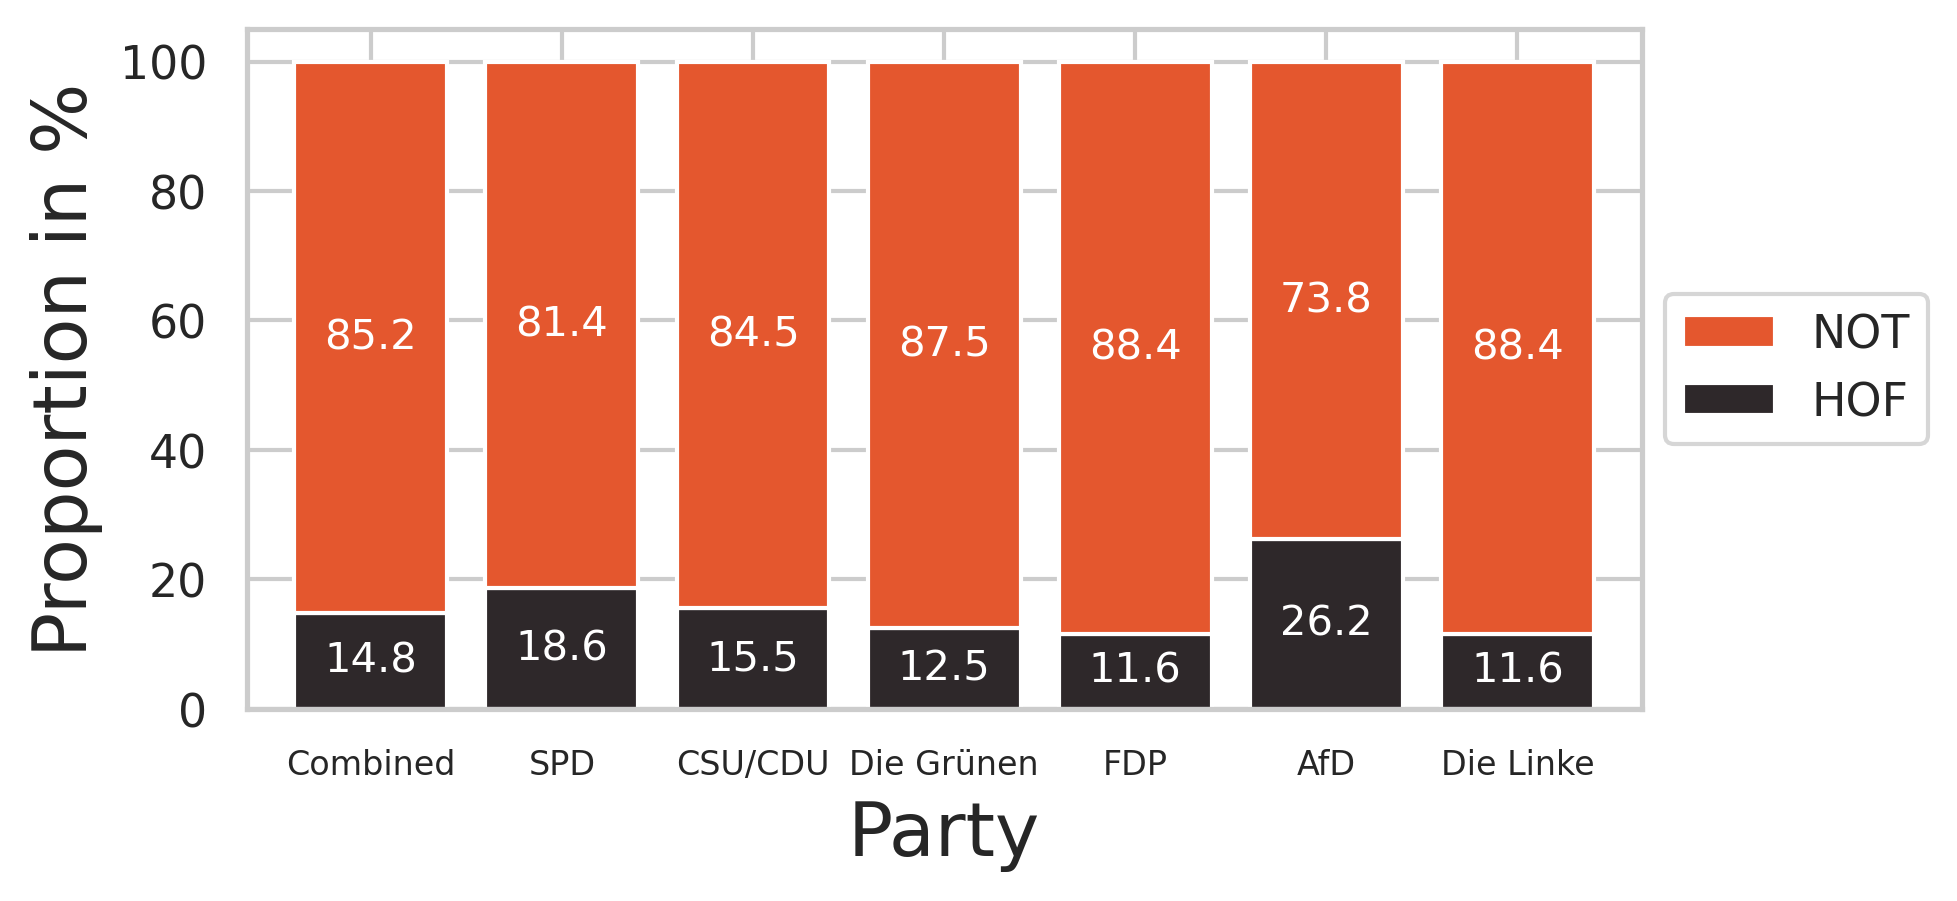

In [59]:
from time_plots import plot_percentage
plot_percentage(df, "plots/control_group/control_group_exploded_percentage_distribution")